In [1]:
!pip install dm-pix

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [7]:
import jax
import jax.numpy as jnp
import dm_pix as pix
import matplotlib.pyplot as plt

In [4]:
x = jnp.array([[0,0,0,0,0],
              [0,0,1,0,0],
              [0,1,1,1,0],
              [0,0,1,0,0],
              [0,0,0,0,0]])

In [9]:
y = jax.image.resize(x, (10,10), "bilinear")

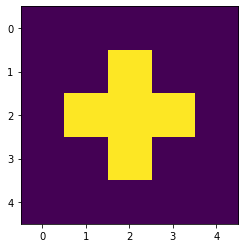

In [12]:
plt.imshow(x)
plt.show()

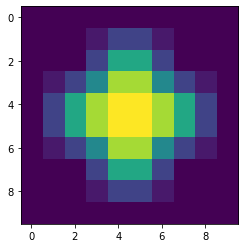

In [13]:
plt.imshow(y)
plt.show()

In [108]:
def pad_axis_0(array, target_size):
    """
    Zero-pads the first axis of a NumPy array to reach the specified target size.
    
    Args:
        array (numpy.ndarray): The input array to pad.
        target_size (int): The desired size along the first axis after padding.
        
    Returns:
        numpy.ndarray: The zero-padded array.
    """
    current_size = array.shape[0]
    if current_size >= target_size:
        return array  # No padding needed if already at or above target size
    
    padding = ((0, target_size - current_size),) + ((0, 0),) * (array.ndim - 1)
    return np.pad(array, padding, mode='constant', constant_values=0)

In [109]:
class _SHD2Raster():
    """ 
    Tool for rastering SHD samples into frames. Packs bits along the temporal axis for memory efficiency. This means
        that the used will have to apply jnp.unpackbits(events, axis=<time axis>) prior to feeding the data to the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        # tensor has dimensions (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        tensor = tensor[:self.sample_T,:]
        tensor = np.minimum(tensor, 1)
        tensor = np.packbits(tensor, axis=0)
        return pad_axis_0(tensor, sample_T//8)

In [15]:
import numpy as np
import tonic
from tonic import datasets, transforms

In [92]:
batch_size=256
sample_T = 128
channels=128
val_size=0.2

In [110]:
shd_timestep = 1e-6
shd_channels = 700
net_channels = channels
net_dt = 1/sample_T
           


obs_shape = tuple([net_channels,])
act_shape = tuple([20,])
        
transform = transforms.Compose([
transforms.Downsample(
    time_factor=shd_timestep / net_dt,
    spatial_factor=net_channels / shd_channels
    ),
    _SHD2Raster(net_channels, sample_T = sample_T)
])
        
train_val_dataset = datasets.SHD("./data", train=True, transform=transform)

In [94]:
def tonic_dataset2jnp(tonic_dataset):
    X = jnp.stack([i[0] for i in tonic_dataset])
    y = jnp.stack([i[1] for i in tonic_dataset])
    return X, y

In [96]:
train_val_dataset.sensor_size

(700, 1, 1)

In [116]:
type(train_val_dataset[0][0])

numpy.ndarray

In [111]:
for i in train_val_dataset:
    print(i[0].shape)

(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)
(16, 128)


KeyboardInterrupt: 

In [112]:
X, y = tonic_dataset2jnp(train_val_dataset)

In [120]:
X[0]

Array([[ 0,  2,  0, ...,  0,  0,  0],
       [ 0, 16,  0, ...,  0,  0,  8],
       [64,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)